# Computational Methods in Economics

## Problem Set 5 - Data Analysis and Function Approximation

#### DEADLINE: Friday, January 24, 6 pm

### Preliminaries

#### Import Modules

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor 

import funapprox_cme as fa

## Question 1

In this question, we are going to apply different algorithms, among them the gradient descent minimization algorithm, on a linear least-squares regression problem. Consider the Bundesliga data set (**BundesligaData.csv**) used in the previous problem set. Let's assume we would like to regress a player's market value on his age, his number of goals and assists. 

(a) Read in the relevant parts of the data set using your preferred method. You should create a Numpy array **X** with the three explanatory variables ("age", "goals", "assists") and a flat Numpy array **y** with the dependent variable ("value"), for all 288 players.

In [2]:
### BEGIN SOLUTION
df = pd.read_csv('BundesligaData.csv', sep = ';')
y = df['value'].values
X = df.loc[:, ('age', 'goals', 'assists')].values
### END SOLUTION

In [3]:
assert np.allclose( X.mean(axis = 0), np.array([25.55555556,  2.63194444,  1.875]) )

(b) Standardize **X**, either by applying the formula in the lecture notes or a scikit-learn function. Next, account for the intercept by adding a column of 1's to **X**. 

In [4]:
### BEGIN SOLUTION
## use scikit-learn for feature scaling
X = preprocessing.scale(X)    
## add column of ones to X    
X = np.column_stack((np.ones( X.shape[0] ), X ))
### END SOLUTION

In [5]:
assert np.allclose( X.mean(axis = 0), np.array([1, 0, 0, 0]) )

(c) Solve the linear LS problem manually, by using the normal equation. That is, compute a flat array **b** with length 4 that contains the coefficients.

In [6]:
### BEGIN SOLUTION
## run OLS manually
b = np.linalg.inv((X.T @ X)) @ X.T @ y
### END SOLUTION

In [7]:
## THIS IS A TEST CELL!
### BEGIN HIDDEN TESTS
b.shape = (4,)
assert np.allclose(b, np.array([ 8.1484375,  -1.31409175,  3.80023302,  1.41791076]))
### END HIDDEN TESTS

(d) Next, solve the linear LS problem with the help of scikit-learn. You should create an object named **lr** that contains the coefficients in its **coef_** attribute. 

In [8]:
### BEGIN SOLUTION
lr = LinearRegression(fit_intercept = False) # we've already added the intercept term in X
lr.fit(X, y)
### END SOLUTION

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [9]:
## THIS IS A TEST CELL!
### BEGIN HIDDEN TESTS
assert np.allclose(lr.coef_, np.array([ 8.1484375,  -1.31409175,  3.80023302,  1.41791076]))
### END HIDDEN TESTS

(e) We now apply (batch) gradient descent to compute the coefficients of the regression problem. You can use the code from the lecture with a learning rate of 0.001 and an initial guess of (0, -0.1, 0.3, 0.1). Report your results in a flat array **b_gd**.

In [10]:
def gd_linear(b, X, y, alpha = 0.001, maxit = 50000, eps = 1e-8):
    """
    Implements the iterative procedure for gradient descent in the context of linear regression. Inputs are 
    -> b: initial guess for the minimizing coefficient vector
    -> X: the m-by-n regression matrix, with each row containing the n features for one observation
    -> y: the m-by-1 vector of target values 
    -> alpha: a scalar indicating the step size from b(k) to b(k+1)
    """
    ### BEGIN SOLUTION
    dist = 1
    it = 0
    m = len(y)  
    while dist > eps and it < maxit:
        it += 1
        s = -alpha * m**(-1) * X.T @ ( X @ b - y )
        dist = np.linalg.norm(s) / (1 + np.linalg.norm(b))
        b = b + s
    
    print("Gradient descent has converged in {} iterations".format(it))
    
    return b

b0 = np.array([0, -0.1, 0.3, 0.1])
b_gd = gd_linear(b0, X, y, show_it = True)

### END SOLUTION

Gradient descent has converged in 15293 iterations


In [11]:
## THIS IS A TEST CELL!
### BEGIN HIDDEN TESTS
assert np.allclose(b_gd, np.array([ 8.14843565, -1.31406499,  3.80011313,  1.41802544]))
### END HIDDEN TESTS

(f) Finally, we compute the coefficients using stochastic gradient descent, with the help of scikit-learn's **SGDRegressor** class. Since it is stochastic, every run will yield slightly different values. To facilitate comparison with the other methods, we run it a large number of times, store the results and then compute the average.  

Set **N = 5000** and define an empty NumPy array **B** of dimension **(N, 4)**. Create an instance of **SGDRegressor** and run its **fit** method **N** times. Store the coefficients of an individual run as a row of **B**. Finally, define an array **b_sgd** as the column mean of **B**.

In [12]:
### BEGIN SOLUTION

N = 5000
B = np.zeros((N, 4))    
sgd = SGDRegressor(fit_intercept = False, tol = 1e-8)
for i in range(N):
    sgd.fit(X, y)
    B[i, :] = sgd.coef_
b_sgd = B.mean(axis = 0)

### END SOLUTION

In [13]:
assert np.allclose(b_sgd, np.array([ 8.15, -1.3133,  3.835,  1.41]), rtol=1e-02, atol=1e-02)

## Question 2

The simplest approach to approximating a univariate function $f$ is (piecewise) linear interpolation. As usually, define a grid $x_1, ..., x_m$ and compute the function values $f(x_1), ... , f(x_m)$. Then, to approximate $f(x)$, find the two grid points $x_i$ and $x_{i+1}$ that bracket $x$, i.e. $x_l \equiv x_i \le x \le x_{i + 1} \equiv x_r $. The interpolant is then given by:

\begin{equation}
    \hat{f}(x)=f(x_{l})+{\frac {f(x_{r})-f(x_{l})}{x_{r}-x_{l}}}(x-x_{l})
\end{equation}

Do not use Numpy's **interp** function throughout this question (but feel free to get accustomed to its syntax and to use it for comparing your results)! 

(a) Write a function **lin_int** that takes three arguments - a scalar **x** at which to approximate the function, a Numpy array **x_grid** consisting of $m$ grid points and a Numpy array **y_grid** containing the function values corresponding to the grid - and that implements this interpolation scheme. 

**Hint**: The slightly tricky part here is to find $x_l$ and $x_r$ for a given $x$. There are different ways to achieve this; one possibility is Numpy's **argwhere** function. You may want to combine this with a **try/except** statement.

In [14]:
### BEGIN SOLUTION
def lin_int(x, x_grid, y_grid):
    """
    Implements one-dimensional piecewise linear interpolation given a grid X and corresponding function values Y, on a point x
    """  
    try:
        pos = np.argwhere(x > x_grid)[-1]
    except:
        pos = 0
            
    return y_grid[pos] + ((y_grid[pos + 1] - y_grid[pos]) / (x_grid[pos + 1] - x_grid[pos])) * (x - x_grid[pos])   
### END SOLUTION

In [15]:
x_grid = np.linspace(0, 5, 6)
y_grid = x_grid**2

assert lin_int(3.5, x_grid, y_grid) == 12.5

(b) Use this function to approximate the sine function $f(x) = \sin(x)$ between 0 and $2\pi$. Use $m = 10$ points for the  approximation grid and approximate the function for $N = 50$ equally-spaced points between 0 and $2\pi$. Your answer should be a Numpy array named **y_approx** of length $N$ that contains the approximated function values.

Plot both the approximated and the true function values.



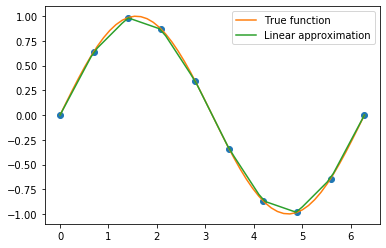

In [18]:
### BEGIN SOLUTION
## define grid and compute function values
m = 10
x_grid = np.linspace(0, 2*np.pi, m)
y_grid = np.sin(x_grid)

## define a dense grid and compute function values
xvals = np.linspace(0, 2*np.pi, 50)
yvals = np.sin(xvals) 

## use lin_int to interpolate function along the dense grid
y_approx = np.zeros(50)
for ind in range(50):
    y_approx[ind] = lin_int(xvals[ind], x_grid, y_grid)

## plot true and approximated function values     
fig, ax = plt.subplots()   
ax.plot(x_grid, y_grid, 'o')
ax.plot(xvals, yvals, label = 'True function')
ax.plot(xvals, y_approx, label = 'Linear approximation')
ax.legend()

### END SOLUTION

In [19]:
assert np.allclose(y_approx.mean(), 0)

In [20]:
assert np.allclose(y_approx.std(), 0.6721265191518054)

## Question 3

This question illustrates why we should use Chebyshev nodes instead of equally spaced (equidistant) nodes. We use *Runge's function* as an example:

\begin{equation}
    f(x) = \frac{1}{1 + \alpha x^2}
\end{equation}

We will approximate this function on the interval $[-5, 5]$ using all possible combinations of equally spaced/Chebyshev nodes for the interpolation grid and monomials/Chebyshev polynomials for the basis functions. 

Note that you can use any built-in function, as well as any function defined in the lecture, to answer this question. The functions from the lecture are collected in the module **funapprox_cme**. 

(a) Start by writing a Python function that implements Runge's function. Then, define a dense grid **x_long** (a Numpy array) with $N = 500$ equally spaced points between $[-5, 5]$. Compute the function values of Runge's function on this grid for $\alpha = 1$ and store them in a flat Numpy array **y_long**. Plot the function values. 

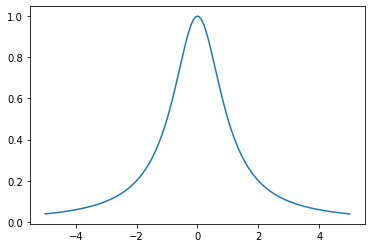

In [21]:
### BEGIN SOLUTION

def fun(x, alpha = 1):
    """
    Runge's Function
    """
    return (1 + alpha * x**2)**(-1)

## dense grid
N = 500
g_min, g_max = -5, 5
x_long = np.linspace(g_min, g_max, N)
y_long = fun(x_long)

fig, ax = plt.subplots()
ax.plot(x_long, y_long)

### END SOLUTION

In [22]:
assert y_long.shape == (500,)
assert np.allclose(y_long.mean(), 0.2742076173424)

(b) Define two grids, one with equally spaced points named **x_eq**, and a Chebyshev grid named **x_cn** between $[-5, 5]$, for $m = 11$ grid points. Compute the function values corresponding to these grids, as **y_eq** and **y_cn**, respectively.

In [23]:
### BEGIN SOLUTION

## min and max for approximation grid
x_min, x_max = -5, 5
## number of grid points
m = 11

## equally spaced nodes
x_eq = np.linspace(x_min, x_max, m)
y_eq = fun(x_eq)
## Chebyshev grid
x_cn = fa.chebgrid(x_min, x_max, m)
y_cn = fun(x_cn)

### END SOLUTION

In [24]:
assert np.allclose(y_eq.sum(), 2.7945701357466)
assert np.allclose(x_cn.std(), 3.5355339059327)

(c) Define a dictionary **coef**. Fill it with the approximation coefficients for each combination of monomials/Chebyshev polynomials for the basis functions and equally spaced/Chebyshev nodes for the interpolation grid. In other words, **coef** should have four key-value pairs, with the keys **"mo_eq"**, **"mo_cn"**, **"ch_eq"** and **"ch_cn"**.  

In [25]:
### BEGIN SOLUTION
## store basis coefficients in dictionary for results
coef = {}

## interpolation step
## monomial basis
coef['mo_eq'] = np.polynomial.polynomial.polyfit(x_eq, y_eq, m - 1) 
coef['mo_cn'] = np.polynomial.polynomial.polyfit(x_cn, y_cn, m - 1) 

## Chebyshev basis
coef['ch_eq'] = np.polynomial.chebyshev.chebfit(fa.chebconvert(x_eq, x_min, x_max), y_eq, m - 1) 
coef['ch_cn'] = fa.chebapprox(y_cn, m - 1) 
### END SOLUTION

In [26]:
assert set(coef.keys()) == {'ch_cn', 'ch_eq', 'mo_cn', 'mo_eq'}

In [27]:
assert np.allclose(coef['mo_eq'], np.array([ 1.00000000e+00,  2.16792293e-14, -6.74208145e-01, -1.00001580e-14,
         1.97375566e-01,  1.54145549e-15, -2.44117647e-02, -8.41873206e-17,
         1.26696833e-03,  1.49905290e-18, -2.26244344e-05]))

In [28]:
assert np.allclose(coef['ch_cn'], np.array([ 2.01135927e-01,  9.44128236e-17, -2.74453603e-01, -1.34367132e-16,
         1.90547928e-01,  3.32789899e-17, -1.37129922e-01,  6.64995782e-17,
         1.05652703e-01, -1.39384165e-16, -9.10799162e-02]))

In [29]:
## THIS IS A TEST CELL!
### BEGIN HIDDEN TESTS
assert np.allclose(coef['mo_cn'], np.array([ 1.00000000e+00,  1.21190576e-15, -4.99060461e-01,  1.57189302e-15,
         9.83088297e-02, -3.24918769e-16, -8.54046435e-03,  1.97974264e-17,
         3.33070947e-04, -4.00170267e-19, -4.77521071e-06])  )

assert np.allclose(coef['ch_eq'], np.array([ 5.88661712e-01,  0.00000000e+00,  3.57428503e-01, -1.90766678e-17,
         3.79356971e-01, -9.92145947e-18, -4.06670894e-01,  8.67437481e-17,
        -4.48787914e-01, -1.38592365e-17, -4.31526840e-01]))
### END HIDDEN TESTS

(d) Across all four approaches to approximate the function, what is the largest approximation error? Report it as a variable named **max_error**. Plot the approximation errors for all four cases in one graph. 

*Optional*: Based on your result, what choice (interpolation grid vs. basis functions) has a bigger impact on the approximation error?

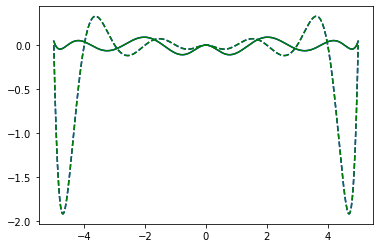

In [30]:
### BEGIN SOLUTION

errors = np.zeros(4)

errors[0] = np.max( abs( y_long - np.polynomial.polynomial.polyval(x_long, coef['mo_eq']))) 
errors[1] = np.max( abs( y_long - np.polynomial.polynomial.polyval(x_long, coef['mo_cn']))) 
errors[2] = np.max( abs( y_long - np.polynomial.chebyshev.chebval(fa.chebconvert(x_long, x_min, x_max), coef['ch_eq']))) 
errors[3] = np.max( abs( y_long - np.polynomial.chebyshev.chebval(fa.chebconvert(x_long, x_min, x_max), coef['ch_cn'])))

max_error = errors.max()

## plot approximation errors
fig, ax = plt.subplots()
ax.plot(x_long, y_long - np.polynomial.polynomial.polyval(x_long, coef['mo_eq']), 'b', linestyle = '--')
ax.plot(x_long, y_long - np.polynomial.polynomial.polyval(x_long, coef['mo_cn']), 'b' )
ax.plot(x_long, y_long - np.polynomial.chebyshev.chebval(fa.chebconvert(x_long, x_min, x_max), coef['ch_eq']), 'g', linestyle = '--' )
ax.plot(x_long, y_long - np.polynomial.chebyshev.chebval(fa.chebconvert(x_long, x_min, x_max), coef['ch_cn']), 'g' )

### END SOLUTION

In [31]:
### BEGIN HIDDEN TESTS
assert np.allclose(max_error, 1.91562084)
### END HIDDEN TESTS